In [24]:
import pandas as pd
import numpy as np
import time
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PyQt5.QtWidgets import (
    QFileDialog,
    QMessageBox,
)

SELECTED_FILE = "uploads/Grad_1-BRSA_.xlsx"
PAGINA = "1-BRSA-1221-MA" 
UNIDADE_PRESSAO = "kgf/cm2/m" # "psi/ft" ou "psi/m" ou "kgf/cm2/m" ou "bar/m"

In [25]:
def read_file():
    selected_file = SELECTED_FILE # Insira aqui o nome do arquivo com a extensão
    sheetTab = PAGINA # Insira aqui o nome da página na qual quer calcular
    dataframe = pd.read_excel(
        selected_file,
        skiprows=1,
        decimal=",",
        sheet_name=sheetTab,
    )
    return dataframe

In [26]:
def get_fluid_color(fluid_name):
    """
    Returns a color based on the type of fluid.
    """
    if "gas" in fluid_name.lower():
        return "#A60628"  # Gas - Red
    elif "oil" in fluid_name.lower():
        return "#467821"  # Oil - Green
    elif "water" in fluid_name.lower():
        return "#0072B2"  # Water - Blue
    else:
        return "gray"  # Default color


def pressure_gradient_classification(
    data, kmeans_number, pressure_unit
):
    # GAS - RED
    # OIL - GREEN
    # WATER - BLUE
    pressao = data.iloc[:, 0]
    prof = data.iloc[:, 1]

    def calculate_slope(ps_a, ps_b):
        if len(ps_a) != len(ps_b):
            raise ValueError("ps_a and ps_b must have the same length")
        coefficients = np.polyfit(ps_a, ps_b, 1)
        return coefficients[0]

    slopes = []
    slope_indices = {}
    for i in range(len(prof) - 1):
        x_values = np.array([prof[i], prof[i + 1]])
        y_values = np.array([pressao[i], pressao[i + 1]])
        slope = calculate_slope(x_values, y_values) * -1
        slopes.append(slope)
        slope_indices[slope] = [i, i + 1]

    # Convert the list of slopes to a numpy array
    slopes_array = np.array([slopes, slopes])

    # Perform KMeans clustering on the slopes
    kmeans = KMeans(n_clusters=kmeans_number, random_state=0).fit(slopes_array.T)

    # Classify the data based on the clusters
    classified_data = [list(kmeans.labels_)[0]] + list(kmeans.labels_)

    def convert_classification(class_data):
        if class_data[0] == 1:
            return [1 - label for label in class_data]
        return class_data

    # Convert the classification labels if necessary
    converted_data = convert_classification(classified_data)

    # Separate the data into two groups based on the classification
    top_values = [
        (prof[i], pressao[i]) for i, label in enumerate(converted_data) if label == 0
    ]
    bottom_values = [
        (prof[i], pressao[i]) for i, label in enumerate(converted_data) if label == 1
    ]

    # Calculate the line of best fit for each group
    top_prof, top_pressao = zip(*top_values)
    bottom_prof, bottom_pressao = zip(*bottom_values)

    slope_top, intercept_top = np.polyfit(top_prof, top_pressao, 1)
    slope_bottom, intercept_bottom = np.polyfit(bottom_prof, bottom_pressao, 1)

    pressure_unit = pressure_unit
    # four pressure units to choose from (psi/ft, psi/m, Kgf/cm2/m, bar/m)

    fluid_pressure = {
        "dry_gas_zero": {
            "name": "Dry gas zero",
            "gradient": {"psi/ft": 0.0, "psi/m": 0.0, "kgf/cm2/m": 0.0, "bar/m": 0.0},
        },
        "dry_gas": {
            "name": "Dry gas",
            "gradient": {"psi/ft": 0.0, "psi/m": 0.0, "kgf/cm2/m": 0.0, "bar/m": 0.0},
        },
        "wet_gas": {
            "name": "Wet gas",
            "gradient": {
                "psi/ft": 0.140,
                "psi/m": 0.459,
                "kgf/cm2/m": 0.030,
                "bar/m": 0.032,
            },
        },
        "oil_limit": {
            "name": "Oil limit",
            "gradient": {
                "psi/ft": 0.300,
                "psi/m": 0.984,
                "kgf/cm2/m": 0.069,
                "bar/m": 0.069,
            },
        },
        "oil_60": {
            "name": "Oil 60°",
            "gradient": {
                "psi/ft": 0.387,
                "psi/m": 1.270,
                "kgf/cm2/m": 0.089,
                "bar/m": 0.087,
            },
        },
        "oil_20": {
            "name": "Oil 20° (heavy)",
            "gradient": {
                "psi/ft": 0.404,
                "psi/m": 1.325,
                "kgf/cm2/m": 0.093,
                "bar/m": 0.091,
            },
        },
        "fresh_water": {
            "name": "Fresh water",
            "gradient": {
                "psi/ft": 0.433,
                "psi/m": 1.421,
                "kgf/cm2/m": 0.100,
                "bar/m": 0.098,
            },
        },
        "sea_water": {
            "name": "Sea Water",
            "gradient": {
                "psi/ft": 0.444,
                "psi/m": 1.457,
                "kgf/cm2/m": 0.102,
                "bar/m": 0.101,
            },
        },
        "salt_sat_water": {
            "name": "Salt sat. Water",
            "gradient": {
                "psi/ft": 0.520,
                "psi/m": 1.706,
                "kgf/cm2/m": 0.120,
                "bar/m": 0.118,
            },
        },
        "salt_max": {
            "name": "Salt sat. Water Max",
            "gradient": {
                "psi/ft": 100.000,
                "psi/m": 100.000,
                "kgf/cm2/m": 100.000,
                "bar/m": 100.000,
            },
        },
    }

    # Get a list of all fluid keys
    fluid_keys = list(fluid_pressure.keys())

    # Initialize an empty dictionary for pressure values
    pressure_values = {}

    # Iterate over each pair of consecutive fluids
    for i in range(len(fluid_keys) - 1):
        # Get the top and bottom fluids
        top_fluid = fluid_keys[i]
        bottom_fluid = fluid_keys[i + 1]

        # Get the pressure gradient values for the top and bottom fluids
        top_pressure = fluid_pressure[top_fluid]["gradient"][pressure_unit]
        bottom_pressure = fluid_pressure[bottom_fluid]["gradient"][pressure_unit]

        # Store the pressure values in the dictionary
        pressure_values[top_fluid] = [top_pressure, bottom_pressure]

    # Remove the first key-value pair from the dictionary
    first_key = next(iter(pressure_values))
    pressure_values.pop(first_key)

    # Initialize the top fluid
    top_fluid = 0

    # Find the fluid that matches the top slope
    for fluid, pressures in pressure_values.items():
        if (
            -1.0 * round(slope_top, 4) >= pressures[0]
            and -1.0 * round(slope_top, 4) < pressures[1]
        ):
            top_fluid = fluid

    # Find the fluid that matches the bottom slope
    for fluid, pressures in pressure_values.items():
        if (
            -1.0 * round(slope_bottom, 4) >= pressures[0]
            and -1.0 * round(slope_bottom, 4) < pressures[1]
        ):
            bottom_fluid = fluid

    # Get the names of the top and bottom fluids
    top_fluid_name = fluid_pressure[top_fluid]["name"]
    bottom_fluid_name = fluid_pressure[bottom_fluid]["name"]

    # Print the names of the top and bottom fluids
    # print(top_fluid_name, "|", bottom_fluid_name)

    x_intercept = (intercept_bottom - intercept_top) / (slope_top - slope_bottom)
    y_intercept = slope_top * x_intercept + intercept_top
    # print("O ponto de interseção das retas é", x_intercept, y_intercept)

    diff = np.diff(top_prof)
    # print(diff)

    # Extended top curve
    mean_cota_top = np.mean(np.diff(top_prof))
    extended_cota_top = list(top_prof) + [(np.min(top_prof) - np.abs(mean_cota_top))]
    extended_pressure_top = np.array(extended_cota_top) * slope_top + intercept_top

    # Extended bot curve
    mean_cota_bot = np.mean(np.diff(bottom_prof))
    extended_cota_bot = [(np.max(bottom_prof) - mean_cota_bot)] + list(bottom_prof)
    extended_pressure_bot = (
        np.array(extended_cota_bot) * slope_bottom + intercept_bottom
    )

    # Calculate the line of best fit for the top and bottom fluids
    line_top = slope_top * np.array(top_prof) + intercept_top
    line_bottom = slope_bottom * np.array(bottom_prof) + intercept_bottom

    messages = []
    messages.append(
        f"Fluido do topo: {top_fluid_name} | Fluido da base: {bottom_fluid_name}"
    )
    messages.append(
        f"O ponto de interseção das retas é {x_intercept:.2f} {y_intercept:.2f}"
    )

    top_fluid_color = get_fluid_color(top_fluid_name)
    bottom_fluid_color = get_fluid_color(bottom_fluid_name)

    return (
        top_pressao,
        top_prof,
        bottom_pressao,
        bottom_prof,
        extended_pressure_top,
        extended_cota_top,
        extended_pressure_bot,
        extended_cota_bot,
        y_intercept,
        x_intercept,
        top_fluid_color,
        top_fluid_name,
        bottom_fluid_name,
        bottom_fluid_color,
        slope_top,
        slope_bottom,
    )

In [27]:
def process_data_for_trends():
        dataframe = read_file()
        kmeans_clusters = 2

        pressure_unit = UNIDADE_PRESSAO # Insira aqui a unidade de pressão
        # "psi/ft" ou "psi/m" ou "kgf/cm2/m" ou "bar/m"

        return pressure_gradient_classification(
            dataframe,
            kmeans_clusters,
            pressure_unit,
        )

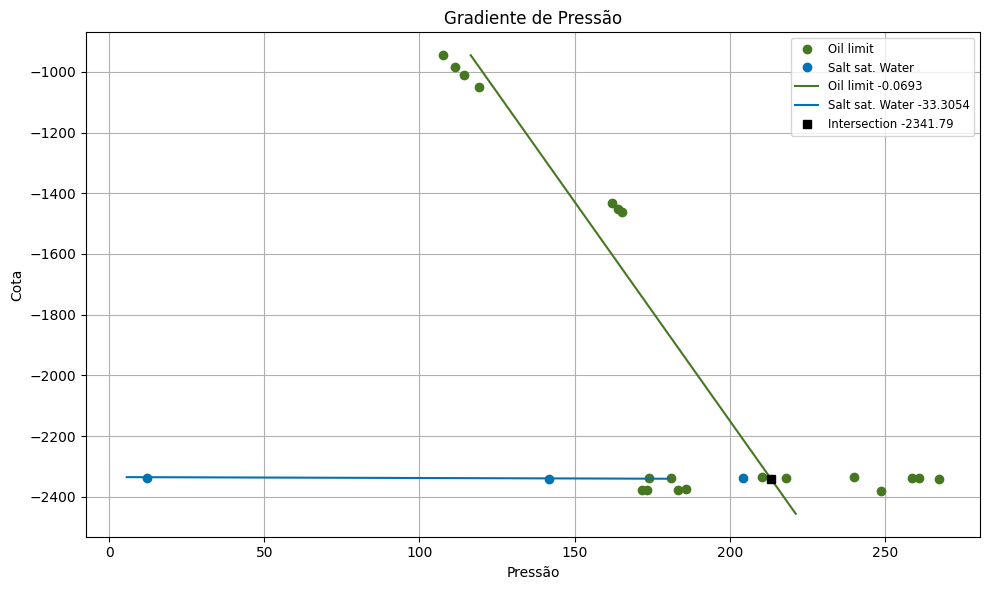

In [28]:
def plot_trends():
        (
            top_pressao,
            top_prof,
            bottom_pressao,
            bottom_prof,
            extended_pressure_top,
            extended_cota_top,
            extended_pressure_bot,
            extended_cota_bot,
            y_intercept,
            x_intercept,
            top_fluid_color,
            top_fluid_name,
            bottom_fluid_name,
            bottom_fluid_color,
            slope_top,
            slope_bottom,
        ) = process_data_for_trends()

        plt.figure(figsize=(10, 6))

        plt.plot(top_pressao, top_prof, "o", c=top_fluid_color, label=top_fluid_name)
        plt.plot(
            bottom_pressao,
            bottom_prof,
            "o",
            c=bottom_fluid_color,
            label=bottom_fluid_name,
        )
        plt.plot(
            extended_pressure_top,
            extended_cota_top,
            c=top_fluid_color,
            label=top_fluid_name + " " + str(round(slope_top, 4)),
        )
        plt.plot(
            extended_pressure_bot,
            extended_cota_bot,
            "-",
            c=bottom_fluid_color,
            label=bottom_fluid_name + " " + str(round(slope_bottom, 4)),
        )
        plt.plot(
            y_intercept,
            x_intercept,
            "s",
            c="k",
            label="Intersection " + str(round(x_intercept, 2)),
        )

        plt.title("Gradiente de Pressão")
        plt.legend(fontsize="small")
        plt.xlabel("Pressão")
        plt.ylabel("Cota")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        
plot_trends()